# Machine Learning Model

> - Predictive model to identify the likelihood of an online session ending in a sale.

In [1]:
# Import Libraries

import re

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
df = pd.read_csv('online_shoppers_intention_modified.csv')
df = df.drop(['Avg_Administrative_Duration', 'Avg_Informational_Duration', 'Avg_ProductRelated_Duration'], axis=1)
df.sample(10)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,SessionQuality_Score
4248,5,200.000000,1,0.00,33,1606.831818,0.000000,0.026619,0.000000,0.0,5,3,2,5,2,2,0,0,16.118619
1205,2,15.000000,0,0.00,7,50.500000,0.000000,0.028571,0.000000,0.0,3,2,2,1,3,2,0,0,2.262500
2331,0,0.000000,0,0.00,3,17.000000,0.066667,0.133333,0.000000,0.0,5,2,2,1,3,2,0,0,0.850000
8941,0,0.000000,0,0.00,3,181.000000,0.066667,0.100000,0.000000,0.0,12,2,2,3,2,2,0,0,9.050000
11951,0,0.000000,1,0.00,21,472.500000,0.019048,0.019048,34.277086,0.0,11,1,1,1,10,2,0,1,17.483971
7894,4,100.066667,0,0.00,30,310.335556,0.000000,0.000481,28.523956,0.0,7,2,2,5,2,2,1,1,17.408929
11263,0,0.000000,0,0.00,15,1390.583333,0.025000,0.050000,39.483371,0.0,12,2,2,2,1,2,0,0,31.991139
7020,10,128.114286,0,0.00,43,811.380952,0.006122,0.026329,14.927978,0.0,10,2,2,5,2,2,0,0,11.794865
10578,0,0.000000,0,0.00,55,946.363636,0.010909,0.025455,0.000000,0.0,11,2,2,6,1,2,1,0,3.379870
9818,9,272.041667,6,502.75,33,3239.418207,0.020000,0.025012,17.028738,0.0,12,1,1,1,2,2,0,0,45.365417


In [3]:
# List of numerical features
num_features = ['Administrative', 'Administrative_Duration', 'Informational', 
                'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
                'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'SessionQuality_Score']

num_features_stats = df[num_features].agg(['min', 'max', 'std']).transpose().reset_index()
num_features_stats.rename(columns={'index': 'Feature name'}, inplace=True)

num_features_stats

,Feature name,min,max,std
0,Administrative,0.0,27.000000,3.321784
1,Administrative_Duration,0.0,3398.750000,176.779107
2,Informational,0.0,24.000000,1.270156
3,Informational_Duration,0.0,2549.375000,140.749294
4,ProductRelated,0.0,705.000000,44.475503
5,ProductRelated_Duration,0.0,63973.522230,1913.669288
6,BounceRates,0.0,0.200000,0.048488
7,ExitRates,0.0,0.200000,0.048597
8,PageValues,0.0,361.763742,18.568437
9,SpecialDay,0.0,1.000000,0.198917


In [4]:
# List of categorical features
cat_features = ['OperatingSystems', 'Browser', 'Region', 
                'TrafficType', 'VisitorType', 'Weekend', 
                'Month', 'Revenue']

unique_counts = {feature: df[feature].nunique() for feature in cat_features}
cat_df = pd.DataFrame(list(unique_counts.items()), columns=['Feature', 'Number of Categories'])

cat_df

,Feature,Number of Categories
0,OperatingSystems,8
1,Browser,13
2,Region,9
3,TrafficType,20
4,VisitorType,3
5,Weekend,2
6,Month,10
7,Revenue,2


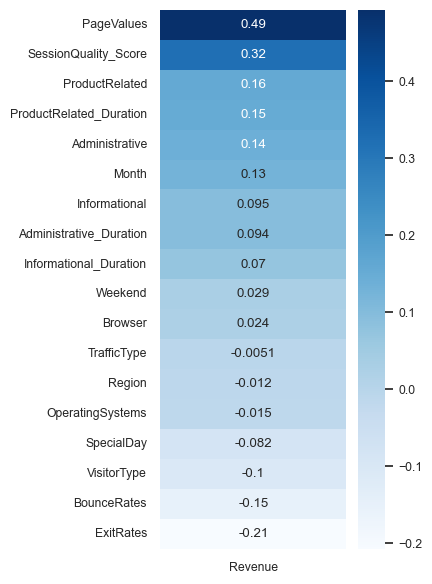

In [5]:
sns.set(font_scale=0.8)
plt.figure(figsize=(3, 7))

# Correlation between all features and the target variable 'Revenue'
corr = df.corr()['Revenue'].sort_values(ascending=False)

corr_df = corr.to_frame()

# Exclude target variable from the plot
corr_df = corr_df.drop('Revenue', axis=0)

sns.heatmap(corr_df, annot=True, cmap='Blues')
# Save the plot as a JPG file
plt.savefig('correlation_features_vs_target2.jpg', dpi=300, bbox_inches='tight')
plt.show()

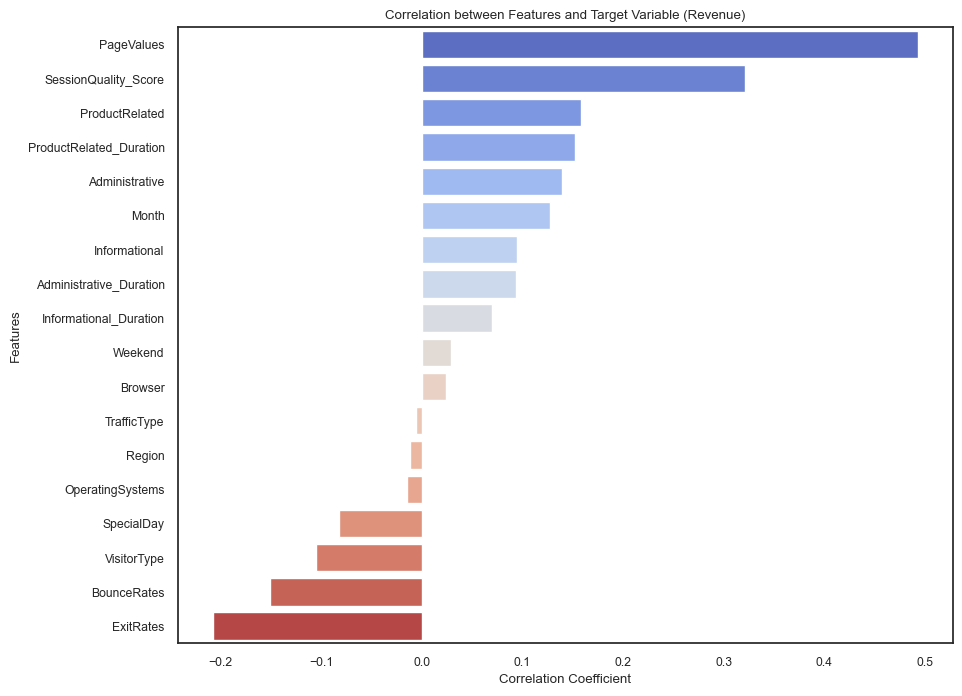

In [6]:
# Exclude target variable from the plot

sns.set_style('white')

plt.figure(figsize=(10, 8))
sns.barplot(x=corr.drop('Revenue'), y=corr.drop('Revenue').index, palette='coolwarm')
plt.title('Correlation between Features and Target Variable (Revenue)')
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')

# Save the plot as a JPG file
plt.savefig('correlation_features_vs_target.jpg', dpi=300, bbox_inches='tight')

plt.show()

## Model Building
> - Train-test split
> - Establishing a Baseline Model
> - Hyperparameter Tuning and Model Selection  

In [7]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set class distribution:')
print(y_train.value_counts())

print('\nTesting set class distribution:')
print(y_test.value_counts())

Training set class distribution:
0    8367
1    1497
Name: Revenue, dtype: int64

Testing set class distribution:
0    2055
1     411
Name: Revenue, dtype: int64


### Baseline Model
> - Using Logistic Regression with default parameter as a baseline model

In [9]:
# Initialize Logistic Regression with default parameters
logistic_model = LogisticRegression(max_iter=1000)

logistic_model.fit(X_train, y_train)

# Predict on training and test data
y_train_pred = logistic_model.predict(X_train)
y_test_pred = logistic_model.predict(X_test)

# Metrics for evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])

baseline_results = {
    'Model': 'Logistic Regression (Baseline)',
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy,
    'Precision': precision,
    'Recall': recall,
    'ROC AUC': roc_auc
}

baseline_results_df = pd.DataFrame([baseline_results])
baseline_results_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,ROC AUC
0,Logistic Regression (Baseline),0.887267,0.869019,0.734043,0.335766,0.85293


### Hyperparameter Tuning

In [10]:
# Pipeline to scale all the variables and then fit a model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

In [11]:
# Hyperparameters to be tested for each model
hyperparameters = {
    'LogisticRegression': {
        'classifier': [LogisticRegression()],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'DecisionTree': {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'RandomForest': {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100],
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 10]
    },
    'AdaBoost': {
        'classifier': [AdaBoostClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1]
    },
    'XGBoost': {
        'classifier': [XGBClassifier()],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    'SVM': {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['linear', 'rbf']
    },
    'KNeighbors': {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7, 10],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
}

## Model Evaluation
> - Assessing Model Performance
> - Cross-Validation Scores: Using GridSearch Cross-Validation for model selection with the best parameters
> - Overfitting Check

## Feature Importance
> Extracting and visualising feature importance

In [12]:
# To store the best model and parameters for each classifier
best_models = {}

for model_name, params in hyperparameters.items():
    grid = GridSearchCV(pipeline, params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    
    # Fit the GridSearchCV object to the training data
    grid.fit(X_train, y_train)
    
    # Store the best model and parameters
    best_models[model_name] = {'best_params': grid.best_params_, 'best_score': grid.best_score_}

best_models

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits


{'LogisticRegression': {'best_params': {'classifier': LogisticRegression(),
   'classifier__C': 1,
   'classifier__penalty': 'l2'},
  'best_score': 0.8852396809257634},
 'DecisionTree': {'best_params': {'classifier': DecisionTreeClassifier(),
   'classifier__max_depth': 5,
   'classifier__min_samples_split': 2},
  'best_score': 0.8991289096514921},
 'RandomForest': {'best_params': {'classifier': RandomForestClassifier(),
   'classifier__max_depth': None,
   'classifier__min_samples_split': 5,
   'classifier__n_estimators': 100},
  'best_score': 0.9051095982374633},
 'GradientBoosting': {'best_params': {'classifier': GradientBoostingClassifier(),
   'classifier__learning_rate': 0.1,
   'classifier__max_depth': 3,
   'classifier__n_estimators': 50},
  'best_score': 0.9053123351862723},
 'AdaBoost': {'best_params': {'classifier': AdaBoostClassifier(),
   'classifier__learning_rate': 1,
   'classifier__n_estimators': 200},
  'best_score': 0.8938568237124096},
 'XGBoost': {'best_params': {'

In [13]:
# 1. Function to plot feature importance.
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
        
        cmap = plt.get_cmap('coolwarm')
        colors = cmap(range(len(importances)))
        
        plt.figure(figsize=(6, 6))
        #sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
        plt.title('Feature Importance')
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
        plt.xlabel('Importance')
        #plt.ylabel('Feature')
        plt.gca().invert_yaxis()
        plt.savefig(f'{type(model).__name__}_Feature_Importance.jpg', dpi=400, bbox_inches='tight')
        plt.show()

In [14]:
# 2. Function to evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = pd.DataFrame(columns=[
        'Model', 
        'Train Accuracy', 'Accuracy', 
        'Train ROC_AUC', 'ROC_AUC',
        'Precision', 'Recall'
    ])
    
    for name, model in models.items():
        classifier = model['best_params']['classifier']
        
        # Fit the model with the best parameters
        classifier.fit(X_train, y_train)

        # Predictions and probabilities on training data
        y_train_pred = classifier.predict(X_train)
        y_train_prob = classifier.predict_proba(X_train)[:, 1] if hasattr(classifier, 'predict_proba') else y_train_pred

        # Predictions and probabilities on test data
        y_test_pred = classifier.predict(X_test)
        y_test_prob = classifier.predict_proba(X_test)[:, 1] if hasattr(classifier, 'predict_proba') else y_test_pred

        # Metrics for training data
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_roc_auc = roc_auc_score(y_train, y_train_prob)

        # Metrics for test data
        accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        roc_auc = roc_auc_score(y_test, y_test_prob)

        # Append results to the DataFrame
        results = results.append({
            'Model': name,
            'Train Accuracy': train_accuracy, 'Accuracy': accuracy,
            'Train ROC_AUC': train_roc_auc, 'ROC_AUC': roc_auc,
            'Precision': precision, 'Recall': recall  
        }, ignore_index=True)

    # Checking potential overfitting
    results['Accuracy Difference'] = results['Train Accuracy'] - results['Accuracy']
    results['ROC_AUC Difference'] = results['Train ROC_AUC'] - results['ROC_AUC']
    return results.sort_values('Accuracy', ascending=False)

results_df = evaluate_models(best_models, X_train, X_test, y_train, y_test)
results_df

,Model,Train Accuracy,Accuracy,Train ROC_AUC,ROC_AUC,Precision,Recall,Accuracy Difference,ROC_AUC Difference
3,GradientBoosting,0.920215,0.894161,0.948651,0.928638,0.732919,0.574209,0.026054,0.020014
2,RandomForest,1.000000,0.892944,1.000000,0.920433,0.745819,0.542579,0.107056,0.079567
5,XGBoost,0.989254,0.891727,0.999211,0.920311,0.701117,0.610706,0.097526,0.078900
4,AdaBoost,0.896391,0.883212,0.928898,0.910309,0.691589,0.540146,0.013179,0.018589
0,LogisticRegression,0.885746,0.870235,0.785687,0.786974,0.726368,0.355231,0.015511,-0.001287
1,DecisionTree,1.000000,0.854826,1.000000,0.735766,0.565432,0.557178,0.145174,0.264234
7,KNeighbors,0.898824,0.848337,0.933847,0.744338,0.601093,0.267640,0.050487,0.189508
6,SVM,0.851075,0.835361,0.509901,0.507056,0.857143,0.014599,0.015714,0.002845


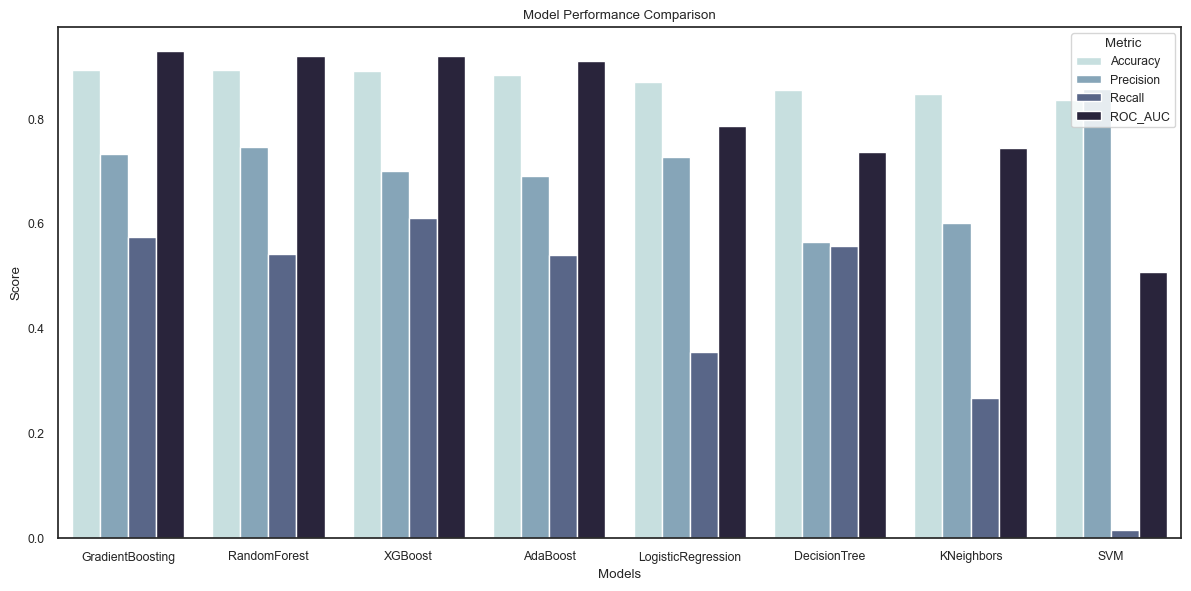

In [15]:
plot_results_df = results_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'ROC_AUC'], var_name='Metric', value_name='Value')

palette = sns.color_palette('ch:start=.2,rot=-.3', 4)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=plot_results_df, x='Model', y='Value', hue='Metric', palette=palette)
ax.set_title('Model Performance Comparison')
ax.set_ylabel('Score')
ax.set_xlabel('Models')
plt.legend(title='Metric')
#plt.xticks(rotation=45) 
plt.tight_layout()
plt.savefig('model_performance_comparison2.jpg', dpi=300, bbox_inches='tight')
plt.show()

Model: GradientBoosting
Accuracy : 0.8942 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7329 [TP / (TP + FP)] Not to label a negative sample as positive. Best: 1, Worst: 0
Recall   : 0.5742 [TP / (TP + FN)] Find all the positive samples. Best: 1, Worst: 0
ROC AUC  : 0.9286 Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
Confusion Matrix:
[[1969   86]
 [ 175  236]]


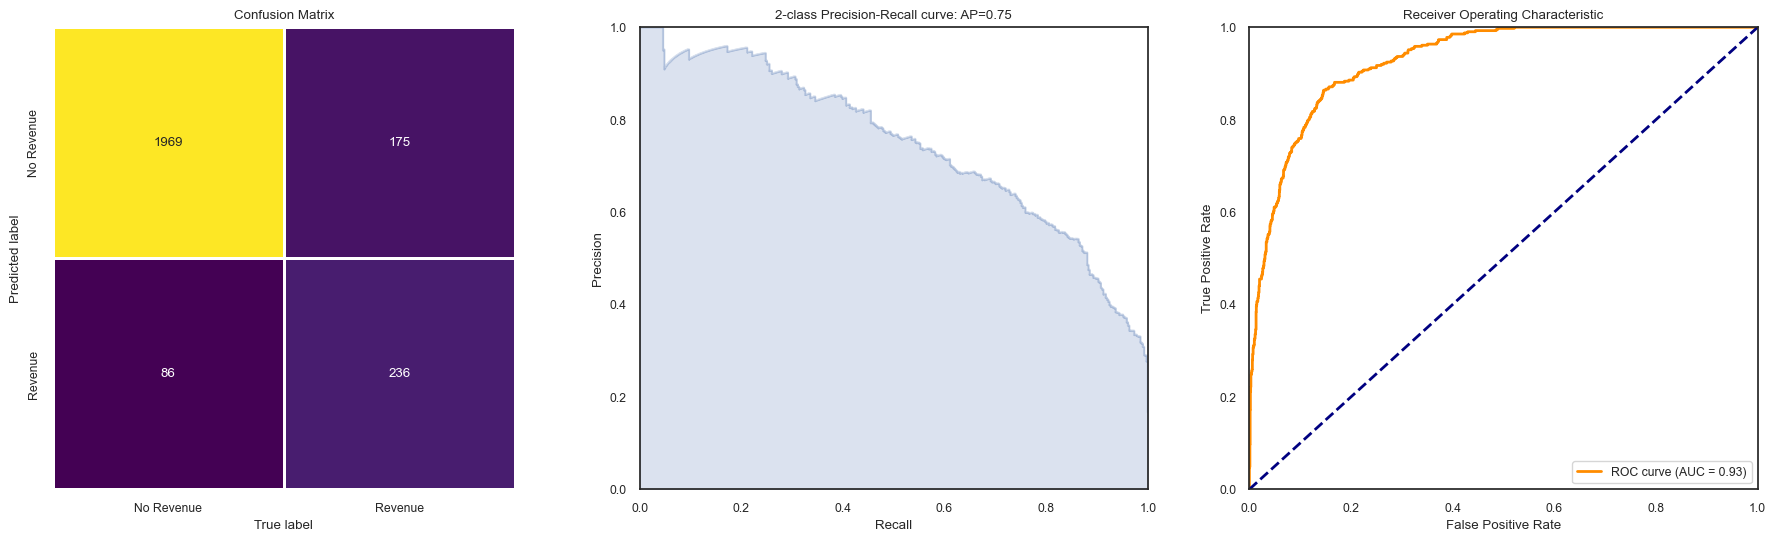

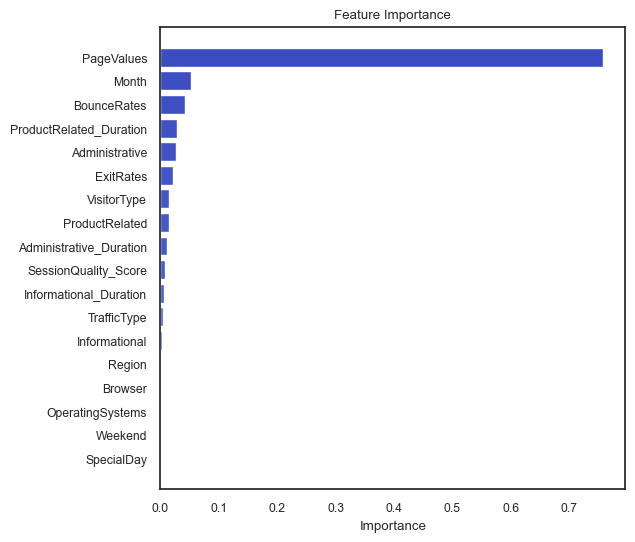

Model: RandomForest
Accuracy : 0.8929 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7475 [TP / (TP + FP)] Not to label a negative sample as positive. Best: 1, Worst: 0
Recall   : 0.5401 [TP / (TP + FN)] Find all the positive samples. Best: 1, Worst: 0
ROC AUC  : 0.9212 Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
Confusion Matrix:
[[1980   75]
 [ 189  222]]


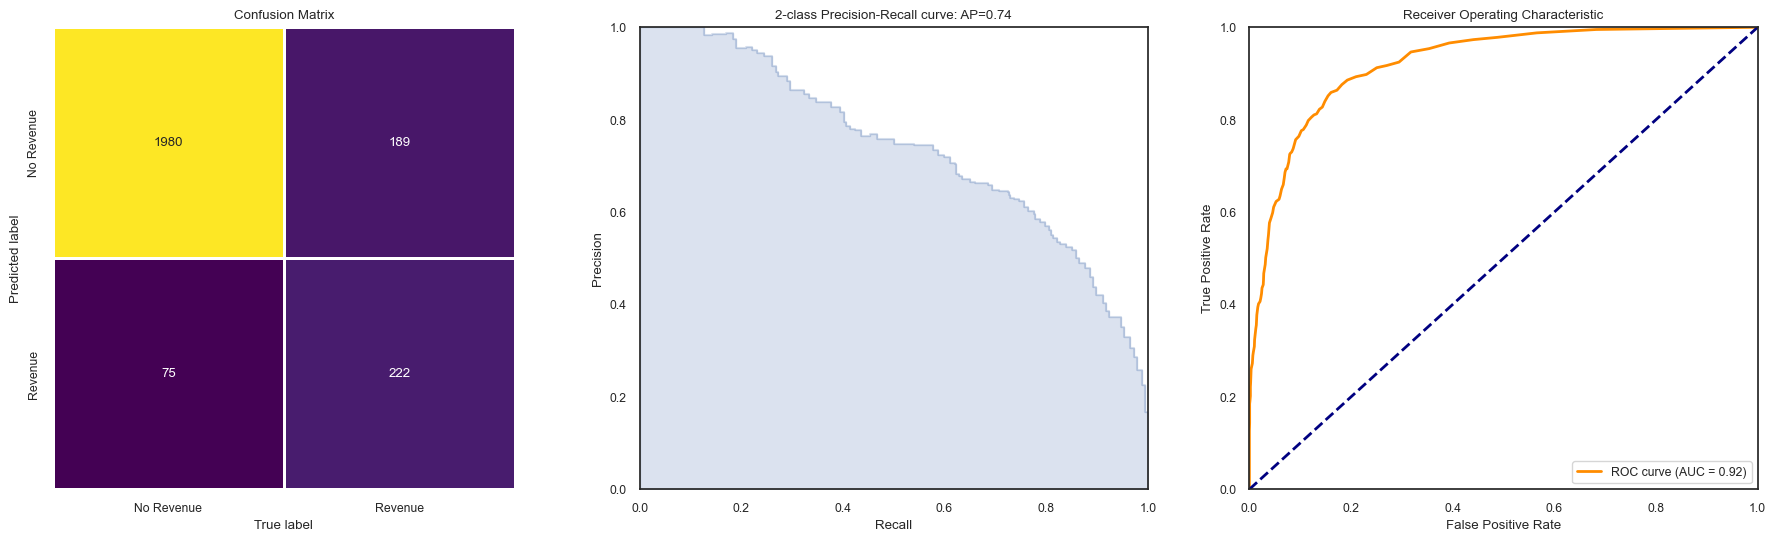

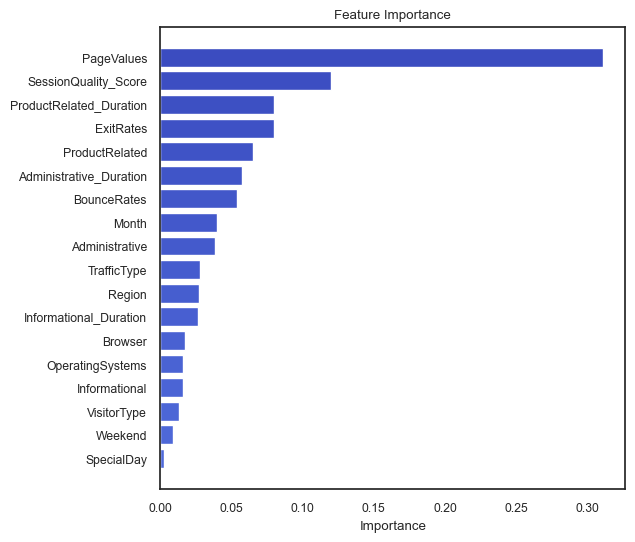

Model: XGBoost
Accuracy : 0.8917 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7011 [TP / (TP + FP)] Not to label a negative sample as positive. Best: 1, Worst: 0
Recall   : 0.6107 [TP / (TP + FN)] Find all the positive samples. Best: 1, Worst: 0
ROC AUC  : 0.9203 Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
Confusion Matrix:
[[1948  107]
 [ 160  251]]


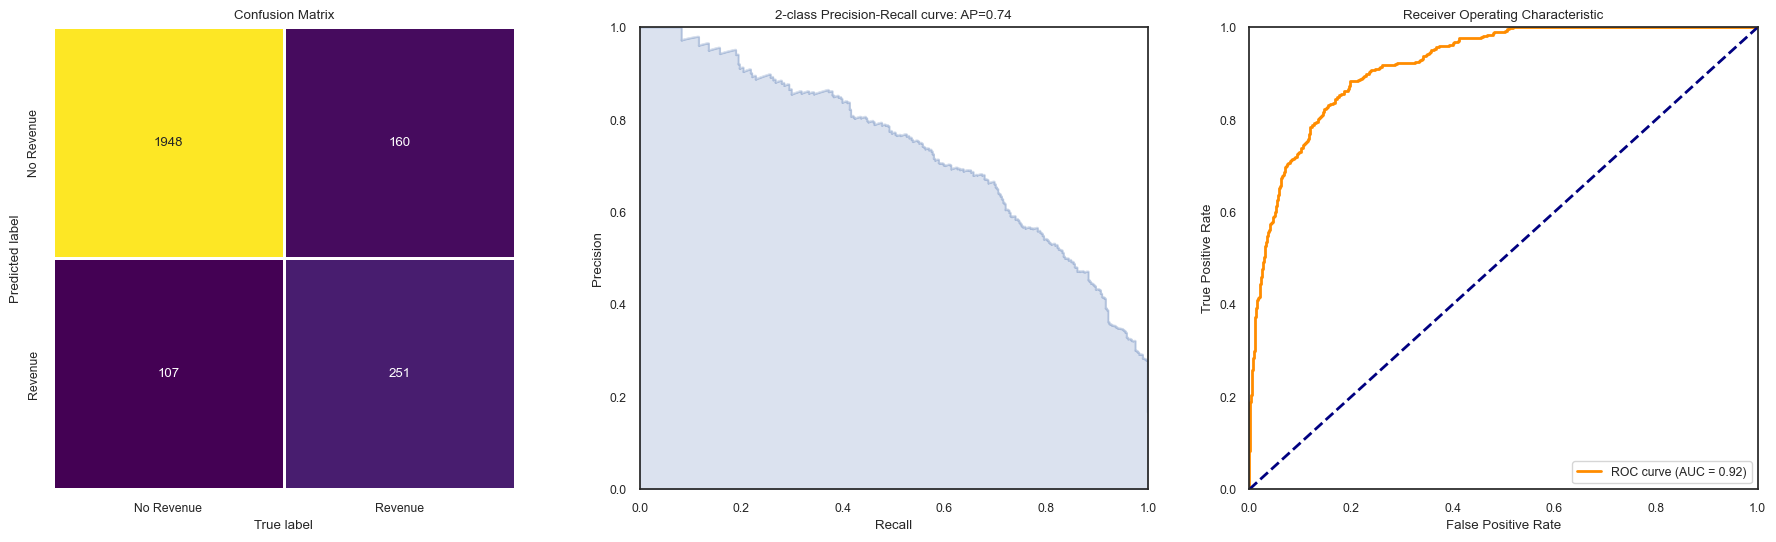

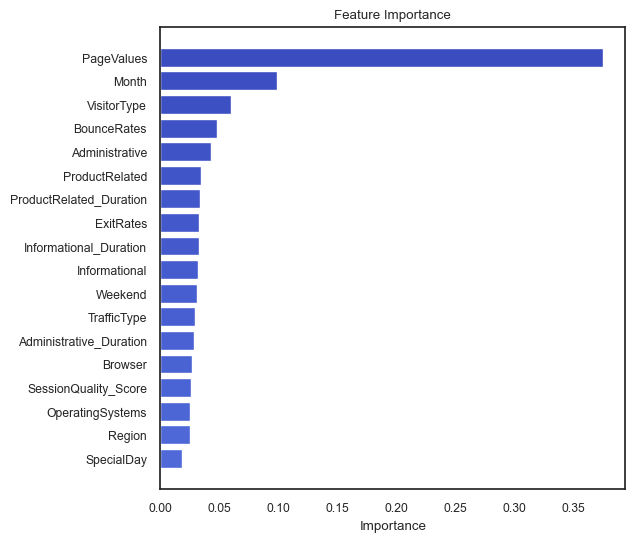

In [24]:
# 3. Function to visualise the top 3 best models

def visualise_best_models(results_df, X_test, y_test, models):
    # Select the top 3 models based on ROC_AUC
    top_models = results_df.nlargest(3, 'ROC_AUC')

    for index, row in top_models.iterrows():
        model_name = row['Model']
        best_model = models[model_name]['best_params']['classifier']

        # Fit the best model
        best_model.fit(X_train, y_train)

        # Make predictions
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else y_pred
        
        # Metrics
        accuracy_ = accuracy_score(y_test, y_pred)
        precision_ = precision_score(y_test, y_pred)
        recall_ = recall_score(y_test, y_pred)
        roc_auc_ = roc_auc_score(y_test, y_prob)
        
        print(f'Model: {model_name}')
        print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
        print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive. Best: 1, Worst: 0' % precision_)
        print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples. Best: 1, Worst: 0' % recall_)
        print('ROC AUC  : %.4f Best: 1, Worst: < 0.5' % roc_auc_)
        print('-' * 107)
        print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

        # Confusion Matrix
        mat = confusion_matrix(y_test, y_pred)
        print('Confusion Matrix:')
        print(mat)

        # Precision/Recall
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        average_precision = average_precision_score(y_test, y_prob)
    
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Plot
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        fig.subplots_adjust(left=0.02, right=0.98, wspace=0.2)

        # Confusion Matrix
        class_names = ['No Revenue', 'Revenue']
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis', linewidths=1, ax=ax[0])
        ax[0].set_title('Confusion Matrix')
        ax[0].set_xlabel('True label')
        ax[0].set_ylabel('Predicted label')
        ax[0].set_xticklabels(class_names, rotation=0)  
        ax[0].set_yticklabels(class_names, rotation=90) 

        # Precision/Recall
        step_kwargs = {'step': 'post'}
        ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
        ax[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
        ax[1].set_ylim([0.0, 1.0])
        ax[1].set_xlim([0.0, 1.0])
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

        # ROC
        ax[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
        ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax[2].set_xlim([0.0, 1.0])
        ax[2].set_ylim([0.0, 1.0])
        ax[2].set_xlabel('False Positive Rate')
        ax[2].set_ylabel('True Positive Rate')
        ax[2].set_title('Receiver Operating Characteristic')
        ax[2].legend(loc='lower right')
        
        # Save the plot as a JPG file for the model
        plt.savefig(f'{model_name}_model_evaluation.jpg', dpi=400, bbox_inches='tight')
        plt.show()
        
        # Feature Importance - Only if the model has this attribute
        if hasattr(best_model, 'feature_importances_'):
            plot_feature_importance(best_model, X_test.columns)

visualise_best_models(results_df, X_test, y_test, best_models)

SVM does not support probability predictions. Skipping ROC curve.


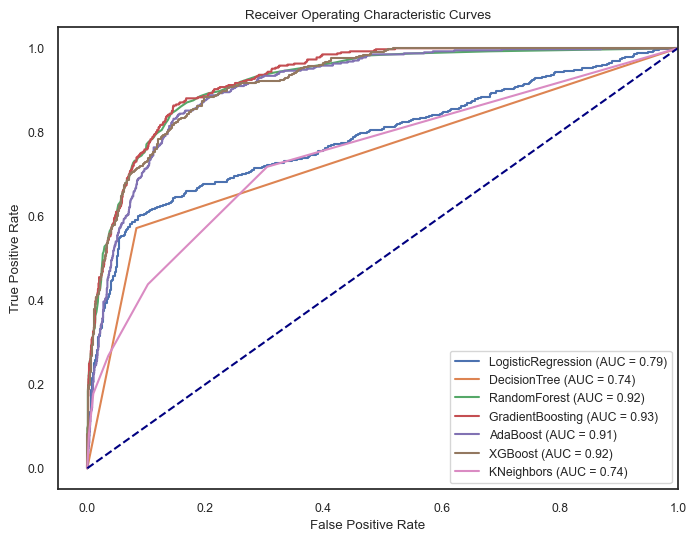

In [18]:
def plot_all_model_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        # Fit the model with the best parameters
        classifier = model['best_params']['classifier']
        classifier.fit(X_train, y_train)

        # Only proceed if the model has predict_proba method to get the probability estimates of the positive class
        if hasattr(classifier, 'predict_proba'):
            y_prob = classifier.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, lw=1.5, label=f'{name} (AUC = {roc_auc:.2f})')
        else:
            # Inform if predict_proba is not available
            print(f'{name} does not support probability predictions. Skipping ROC curve.')

    plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curves')
    plt.legend(loc='lower right')
    plt.savefig('ROC_curves.jpg', dpi=400, bbox_inches='tight')
    plt.show()

plot_all_model_roc_curves(best_models, X_test, y_test)

## Comparative Learning Curves
> - Evaluating model generalisation from the training data to unseen data

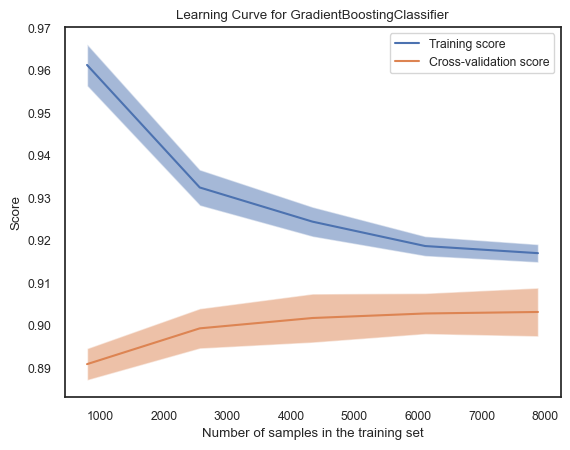

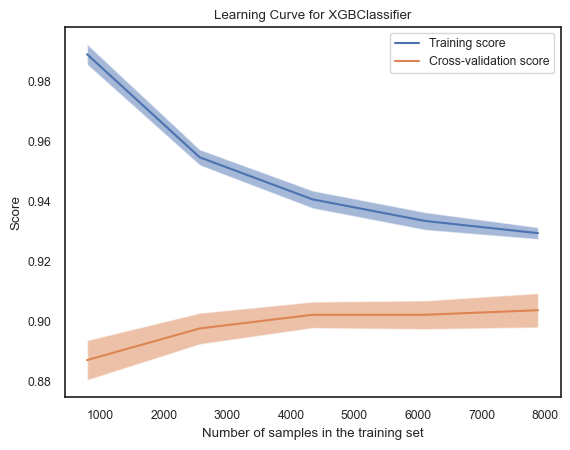

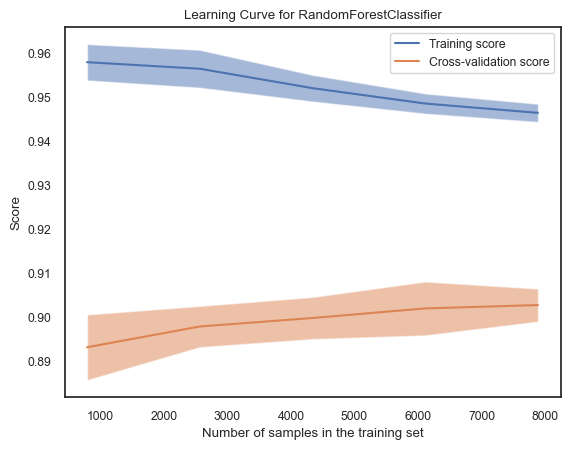

In [19]:
# Reference from ScikitLearn documentation

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

# GradientBoosting with hyperparameters for the best model
gradient_boosting = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)

# RandomForest with hyperparameters for the best model
random_forest = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50)

# XGBoost with hyperparameters for the best model
xgboost = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, use_label_encoder=False, eval_metric='logloss')

# Cross-validation strategy
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Note: Need X_train and y_train defined here
def plot_learning_curve_cv(models, X_train, y_train, cv):
    for model in models:
        fig, ax = plt.subplots()
        LearningCurveDisplay.from_estimator(model, X_train, y_train, cv=cv, n_jobs=-1, ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:2], ['Training score', 'Cross-validation score'])
        ax.set_title(f'Learning Curve for {model.__class__.__name__}')
        plt.savefig(f'learning_curve_cv_{model.__class__.__name__}.jpg', dpi=300, bbox_inches='tight')
        plt.show()

models = [gradient_boosting, xgboost, random_forest]

plot_learning_curve_cv(models, X_train, y_train, cv)

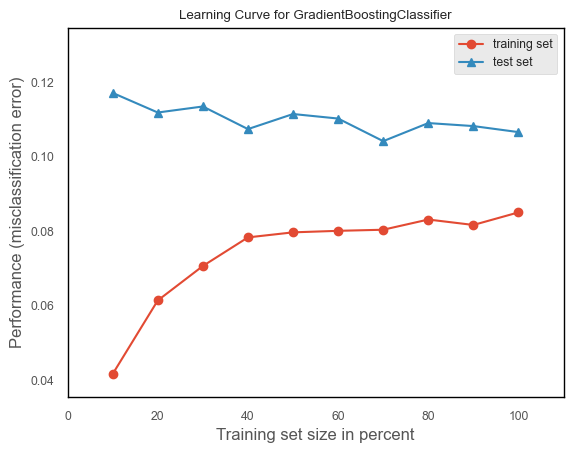

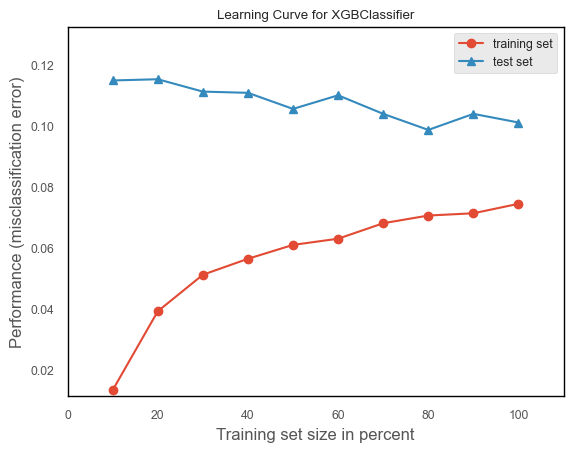

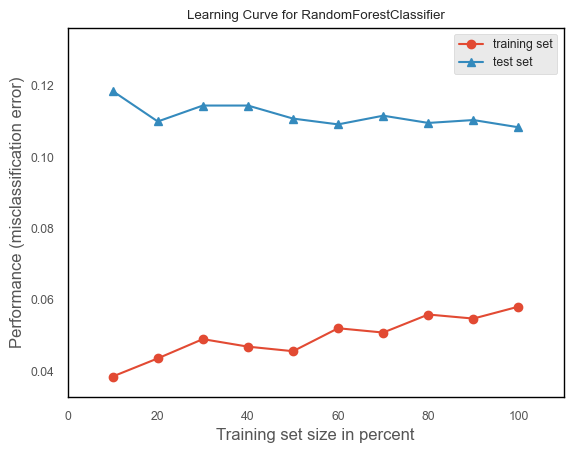

In [20]:
from mlxtend.plotting import plot_learning_curves

# GradientBoosting with hyperparameters for the best model
gradient_boosting = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)

# XGBoost with hyperparameters for the best model
xgboost = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, use_label_encoder=False, eval_metric='logloss')

# RandomForest with hyperparameters for the best model
random_forest = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50)

def plot_all_learning_curves(models, X_train, y_train, X_test, y_test):
    for model in models:
        plt.figure()
        plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')
        plt.title(f'Learning Curve for {model.__class__.__name__}')
        plt.gca().set_facecolor('white')
        plt.gca().spines['top'].set_color('black')
        plt.gca().spines['right'].set_color('black')
        plt.gca().spines['left'].set_color('black')
        plt.gca().spines['bottom'].set_color('black')
        plt.grid(False)
        plt.savefig(f'learning_curve_{model.__class__.__name__}.jpg', dpi=300, bbox_inches='tight')
        plt.show()

models = [gradient_boosting, xgboost, random_forest]

plot_all_learning_curves(models, X_train, y_train, X_test, y_test)

## Analysis
> As the number samples increases, the training and validation score should converge.

## Prediction with Selected Model
> - Revenue outcomes prediction using hypothetical user input

In [21]:
df[['PageValues', 'SessionQuality_Score', 'ExitRates', 'ProductRelated_Duration', 'BounceRates']].describe()

,PageValues,SessionQuality_Score,ExitRates,ProductRelated_Duration,BounceRates
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,5.889258,13.984522,0.043073,1194.746220,0.022191
std,18.568437,15.703764,0.048597,1913.669288,0.048488
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.375081,0.014286,184.137500,0.000000
50%,0.000000,9.333982,0.025156,598.936905,0.003112
75%,0.000000,18.207907,0.050000,1464.157214,0.016813
max,361.763742,282.200000,0.200000,63973.522230,0.200000


In [22]:
# Predicting sales outcome using Random Forest model based on hypothetical user input 

user_input = {
    'Administrative': 0,
    'Administrative_Duration': 50.0,
    'Informational': 0,
    'Informational_Duration': 10.0,
    'ProductRelated': 1,
    'ProductRelated_Duration': 200.0,
    'BounceRates': 0.05,
    'ExitRates': 0.20,
    'PageValues': 2.0,
    'SpecialDay': 0.0,
    'Month': 2,
    'OperatingSystems': 1,
    'Browser': 1,
    'Region': 1,
    'TrafficType': 1,
    'VisitorType': 2,
    'Weekend': 0,
    'SessionQuality_Score': 9.0
}

user_df = pd.DataFrame([user_input])
prediction = random_forest.predict(user_df)
print(prediction)

[0]


In [23]:
# Predicting sales outcome using XGBoost model based on hypothetical user input 

user_input = {
    'Administrative': 0,
    'Administrative_Duration': 50.0,
    'Informational': 0,
    'Informational_Duration': 10.0,
    'ProductRelated': 1,
    'ProductRelated_Duration': 200.0,
    'BounceRates': 0.05,
    'ExitRates': 0.20,
    'PageValues': 2.0,
    'SpecialDay': 0.0,
    'Month': 2,
    'OperatingSystems': 1,
    'Browser': 1,
    'Region': 1,
    'TrafficType': 1,
    'VisitorType': 2,
    'Weekend': 0,
    'SessionQuality_Score': 9.0
}

user_df = pd.DataFrame([user_input])
prediction = xgboost.predict(user_df)
print(prediction)

[0]


## Model Evaluation Analysis
> In the context of predicting the likelihood of a session ending in a sale, the RandomForest model provides valuable insights into the factors influencing sales conversions. While GradientBoosting exhibits slightly higher performance metrics, the RandomForest interpretability is a significant advantage for several reasons:

> - Feature Influence: RandomForest allows us to quantify the influence of various features on sales outcomes. This can guide business strategies to optimise those features that most strongly predict sales, such as improving page values or session quality.
> - Decision Transparency: The model provides transparency in its predictions, crucial for understanding the customer journey. Businesses can trace the decision path, gaining insights into why certain sessions are more likely to result in sales.

> Therefore, for a business aiming to enhance the likelihood of sessions ending in sales, RandomForest not only delivers strong predictive performance but also provides the transparency needed to understand and act upon the model's findings, which is vital for strategic decision-making and improving customer experience.